In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

Data Loading

In [3]:

file_path = '../data/togo-dapaong_qc.csv'
# Output: Cleaned Sierra Leone data
output_file_path = '../data/togo_clean.csv'

# Load the data
df = pd.read_csv(file_path)

# Process the Timestamp and set it as the index
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M')
df = df.set_index('Timestamp')

print("Togo dapaong Data loaded and indexed successfully.")
print("\n--- Initial Data Profile ---")
df.info()
print("\nSummary Statistics:")
print(df.describe().T)

Togo dapaong Data loaded and indexed successfully.

--- Initial Data Profile ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2021-10-25 00:01:00 to 2022-10-25 00:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   GHI            525600 non-null  float64
 1   DNI            525600 non-null  float64
 2   DHI            525600 non-null  float64
 3   ModA           525600 non-null  float64
 4   ModB           525600 non-null  float64
 5   Tamb           525600 non-null  float64
 6   RH             525600 non-null  float64
 7   WS             525600 non-null  float64
 8   WSgust         525600 non-null  float64
 9   WSstdev        525600 non-null  float64
 10  WD             525600 non-null  float64
 11  WDstdev        525600 non-null  float64
 12  BP             525600 non-null  int64  
 13  Cleaning       525600 non-null  int64  
 14  Precipitation  525600 non-null  float64
 15  TMod

Outlier and basic cleaning

In [4]:


print("\n--- Outlier Detection and Cleaning ---")

# 1. Define Target Columns for Z-Score and Imputation
Z_SCORE_COLS = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
IMPUTATION_COLS = Z_SCORE_COLS + ['Tamb', 'RH', 'BP']

# Calculate Z-scores and identify rows with outliers (used only for the flag)
for col in Z_SCORE_COLS:
    if df[col].std() != 0:
        df[f'{col}_ZScore'] = np.abs((df[col] - df[col].mean()) / df[col].std())
    else:
        df[f'{col}_ZScore'] = 0

outlier_condition = (df[[f'{col}_ZScore' for col in Z_SCORE_COLS]] > 3).any(axis=1)
print(f"Total rows flagged as Z-score outliers: {outlier_condition.sum()}")

# Drop the temporary ZScore columns
df = df.drop(columns=[f'{col}_ZScore' for col in Z_SCORE_COLS])

# 2. Impute Missing Values and any identified outliers using the Median
for col in IMPUTATION_COLS:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

print("✅ Cleaning (Median Imputation) applied to key columns.")


# --- STEP 6: Export Cleaned Data ---
df.to_csv(output_file_path, index=True)

print(f"\n✅ Cleaned DataFrame successfully exported to: {output_file_path}")
print("\nCleaned Data Info Check:")
df.info()


--- Outlier Detection and Cleaning ---
Total rows flagged as Z-score outliers: 9251
✅ Cleaning (Median Imputation) applied to key columns.

✅ Cleaned DataFrame successfully exported to: ../data/togo_clean.csv

Cleaned Data Info Check:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2021-10-25 00:01:00 to 2022-10-25 00:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   GHI            525600 non-null  float64
 1   DNI            525600 non-null  float64
 2   DHI            525600 non-null  float64
 3   ModA           525600 non-null  float64
 4   ModB           525600 non-null  float64
 5   Tamb           525600 non-null  float64
 6   RH             525600 non-null  float64
 7   WS             525600 non-null  float64
 8   WSgust         525600 non-null  float64
 9   WSstdev        525600 non-null  float64
 10  WD             525600 non-null  float64
 11  WDstdev        525600 non-nul

Clean Impact

In [5]:

print("Reloading raw data for cleaning impact analysis...")

# Use a new variable (df_impact) to keep the data raw initially
file_path = '../data/togo-dapaong_qc.csv'
df_impact = pd.read_csv(file_path)
df_impact['Timestamp'] = pd.to_datetime(df_impact['Timestamp'], format='%Y-%m-%d %H:%M')
df_impact = df_impact.set_index('Timestamp')

# Define Target Columns and Z-Score Calculation
Z_SCORE_COLS = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
IMPUTATION_COLS = Z_SCORE_COLS + ['Tamb', 'RH', 'BP']

# 1. Create a "Cleaning_Flag" on the raw data (df_impact)
for col in Z_SCORE_COLS:
    if df_impact[col].std() != 0:
        z_scores = np.abs((df_impact[col] - df_impact[col].mean()) / df_impact[col].std())
        df_impact[f'{col}_ZScore'] = z_scores
    else:
        df_impact[f'{col}_ZScore'] = 0

outlier_condition = (df_impact[[f'{col}_ZScore' for col in Z_SCORE_COLS]] > 3).any(axis=1)
df_impact['Cleaning_Flag'] = outlier_condition # THIS IS THE FLAG FOR THE PLOT

# Drop temporary ZScore columns
df_impact = df_impact.drop(columns=[f'{col}_ZScore' for col in Z_SCORE_COLS])


# 2. Apply Imputation and store the result in new '_Clean' columns
for col in IMPUTATION_COLS:
    # Use the original column data for the median to ensure consistency
    median_val = df_impact[col].median() 
    # Store the cleaned values in a new column (e.g., 'ModA_Clean')
    df_impact[f'{col}_Clean'] = df_impact[col].fillna(median_val)
    
print(f"Data reloaded. {df_impact['Cleaning_Flag'].sum()} rows flagged. Cleaned columns created for comparison.")

Reloading raw data for cleaning impact analysis...
Data reloaded. 9251 rows flagged. Cleaned columns created for comparison.


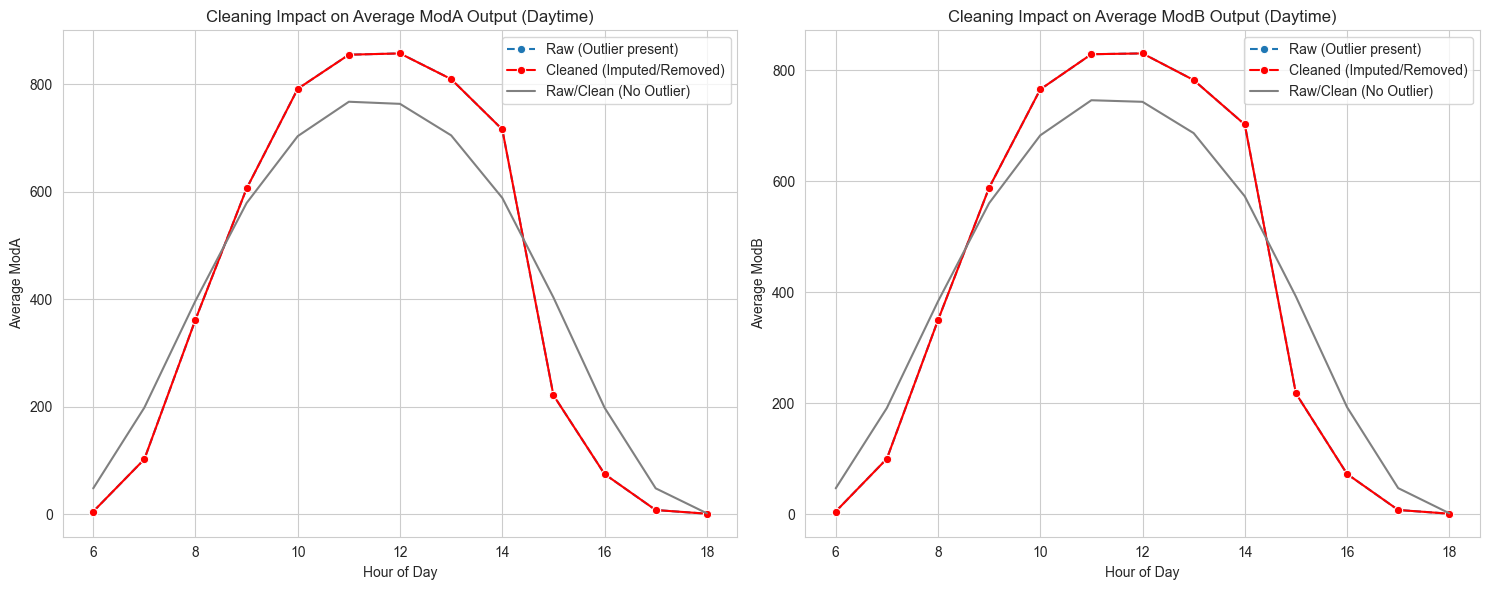

In [6]:

impact_data = df_impact.copy()
impact_data['Hour'] = impact_data.index.hour

# Calculate the mean of the raw (ModA/ModB) and cleaned (ModA_Clean/ModB_Clean) columns
hourly_impact = impact_data.groupby(['Hour', 'Cleaning_Flag'])[['ModA', 'ModB', 'ModA_Clean', 'ModB_Clean']].mean().reset_index()

# Filter for only the hours where solar generation is expected (daytime)
hourly_impact = hourly_impact[(hourly_impact['Hour'] >= 6) & (hourly_impact['Hour'] <= 18)]

plt.figure(figsize=(15, 6))

# Plot 1: Impact on ModA
plt.subplot(1, 2, 1)
# 1. Plot raw data flagged as TRUE (Outlier present)
sns.lineplot(data=hourly_impact[hourly_impact['Cleaning_Flag'] == True], x='Hour', y='ModA', label='Raw (Outlier present)', linestyle='--', marker='o')
# 2. Plot cleaned data flagged as TRUE (Where the change happens)
sns.lineplot(data=hourly_impact[hourly_impact['Cleaning_Flag'] == True], x='Hour', y='ModA_Clean', label='Cleaned (Imputed/Removed)', linestyle='-', marker='o', color='red')
# 3. Plot the data not flagged (The baseline, should show little change)
sns.lineplot(data=hourly_impact[hourly_impact['Cleaning_Flag'] == False], x='Hour', y='ModA', label='Raw/Clean (No Outlier)', linestyle='-', color='gray')

plt.title('Cleaning Impact on Average ModA Output (Daytime)')
plt.ylabel('Average ModA')
plt.xlabel('Hour of Day')
plt.legend()

# Plot 2: Impact on ModB (Repeat for ModB)
plt.subplot(1, 2, 2)
sns.lineplot(data=hourly_impact[hourly_impact['Cleaning_Flag'] == True], x='Hour', y='ModB', label='Raw (Outlier present)', linestyle='--', marker='o')
sns.lineplot(data=hourly_impact[hourly_impact['Cleaning_Flag'] == True], x='Hour', y='ModB_Clean', label='Cleaned (Imputed/Removed)', linestyle='-', marker='o', color='red')
sns.lineplot(data=hourly_impact[hourly_impact['Cleaning_Flag'] == False], x='Hour', y='ModB', label='Raw/Clean (No Outlier)', linestyle='-', color='gray')

plt.title('Cleaning Impact on Average ModB Output (Daytime)')
plt.ylabel('Average ModB')
plt.xlabel('Hour of Day')
plt.legend()

plt.tight_layout()
plt.show()

Time Analysis and diurnal analysis

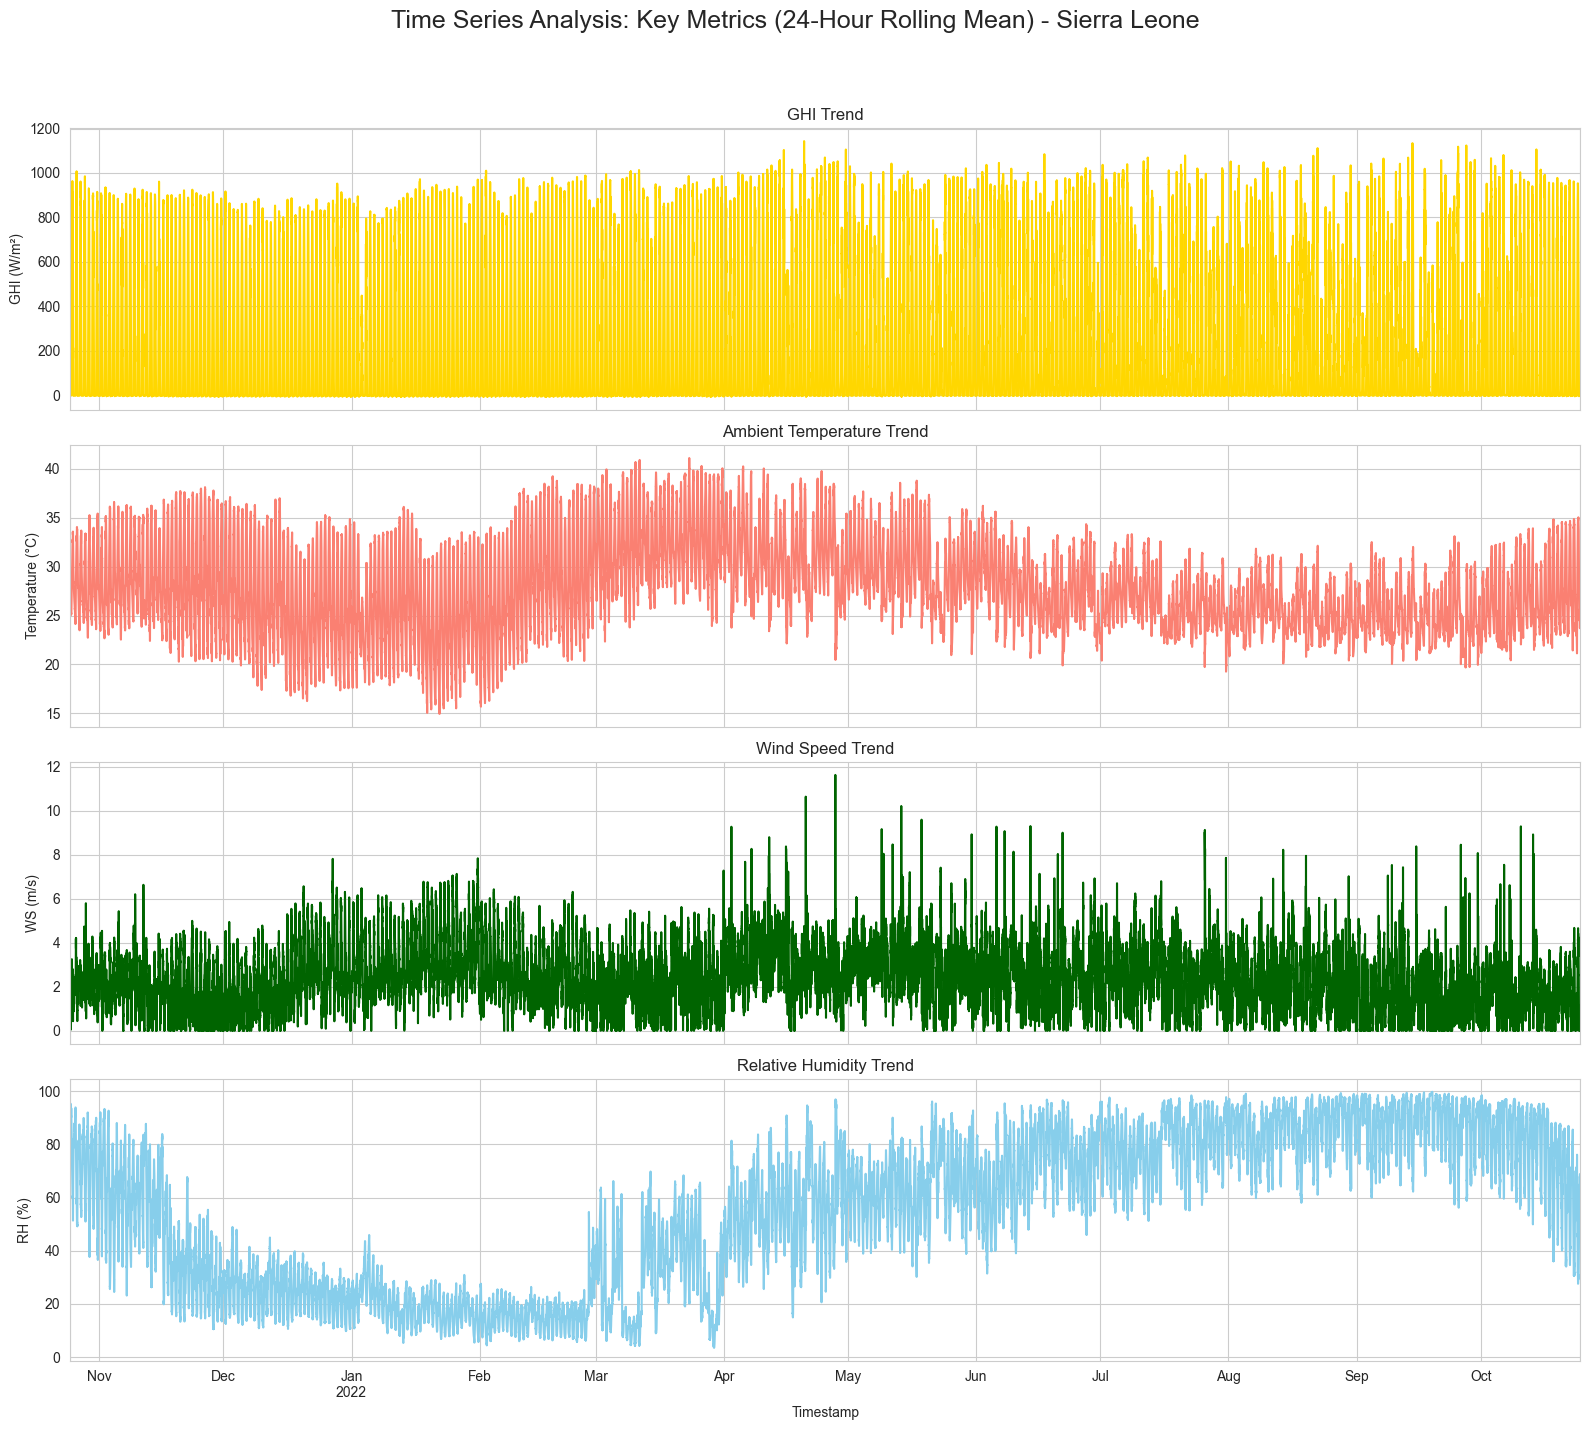

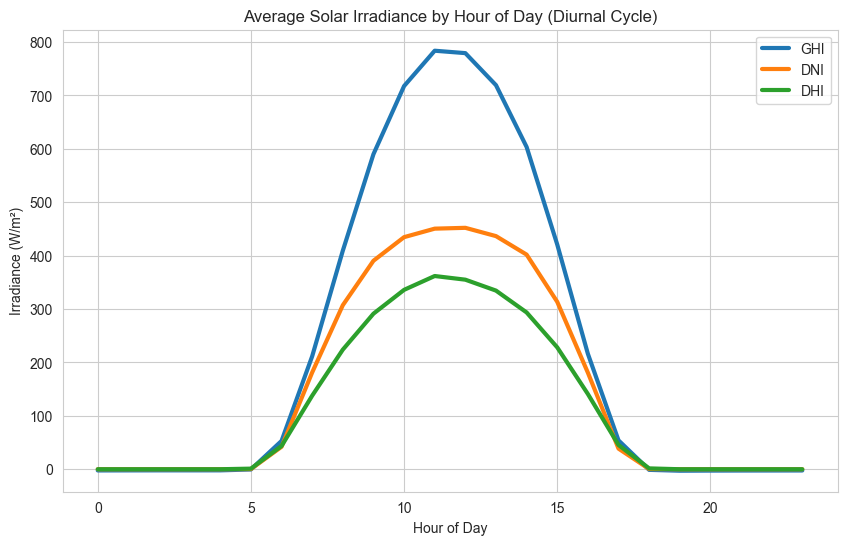

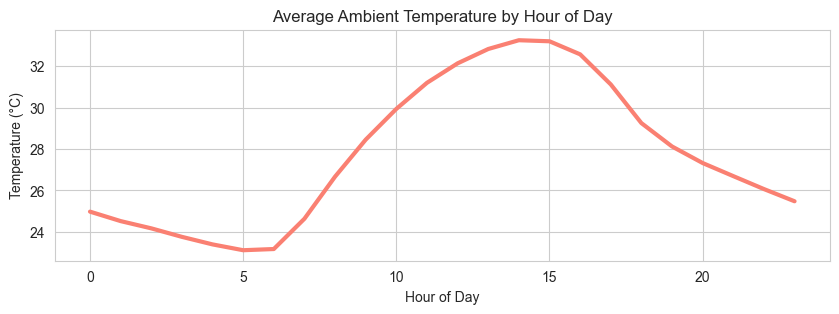

In [7]:


# Overall Trend Visualization
fig, axes = plt.subplots(4, 1, figsize=(16, 15), sharex=True)
fig.suptitle('Time Series Analysis: Key Metrics (24-Hour Rolling Mean) - Sierra Leone', fontsize=18)

df['GHI'].rolling(window=24).mean().plot(ax=axes[0], title='GHI Trend', color='gold')
axes[0].set_ylabel('GHI (W/m²)')

df['Tamb'].rolling(window=24).mean().plot(ax=axes[1], title='Ambient Temperature Trend', color='salmon')
axes[1].set_ylabel('Temperature (°C)')

df['WS'].rolling(window=24).mean().plot(ax=axes[2], title='Wind Speed Trend', color='darkgreen')
axes[2].set_ylabel('WS (m/s)')

df['RH'].rolling(window=24).mean().plot(ax=axes[3], title='Relative Humidity Trend', color='skyblue')
axes[3].set_ylabel('RH (%)')
axes[3].set_xlabel('Timestamp')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Diurnal (Hourly) Pattern Visualization
df['Hour'] = df.index.hour
hourly_avg = df.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

fig, ax = plt.subplots(figsize=(10, 6))
hourly_avg[['GHI', 'DNI', 'DHI']].plot(ax=ax, linewidth=3)
ax.set_title('Average Solar Irradiance by Hour of Day (Diurnal Cycle)')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Irradiance (W/m²)')
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
hourly_avg['Tamb'].plot(ax=ax, color='salmon', linewidth=3)
ax.set_title('Average Ambient Temperature by Hour of Day')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Temperature (°C)')
plt.show()

Correlation and Relationship analysis

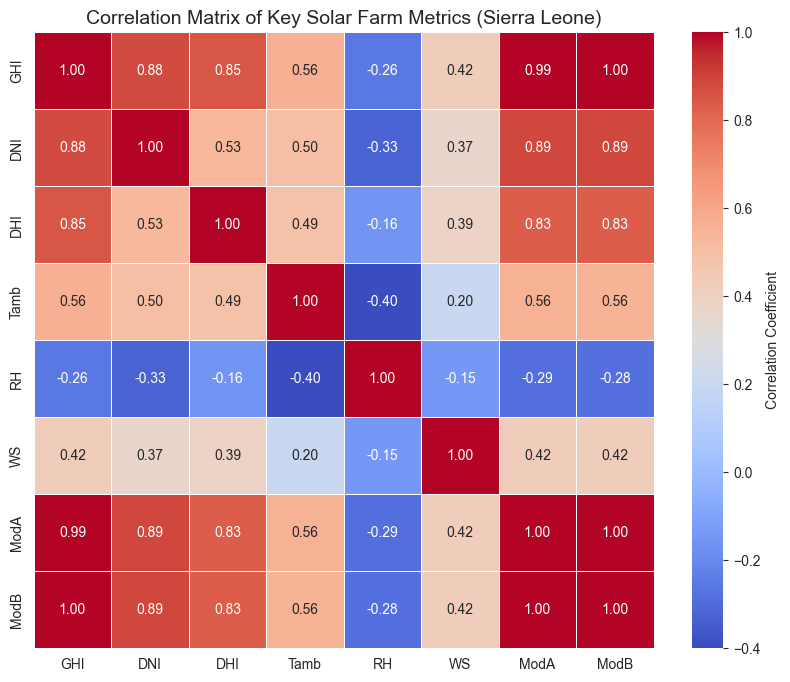

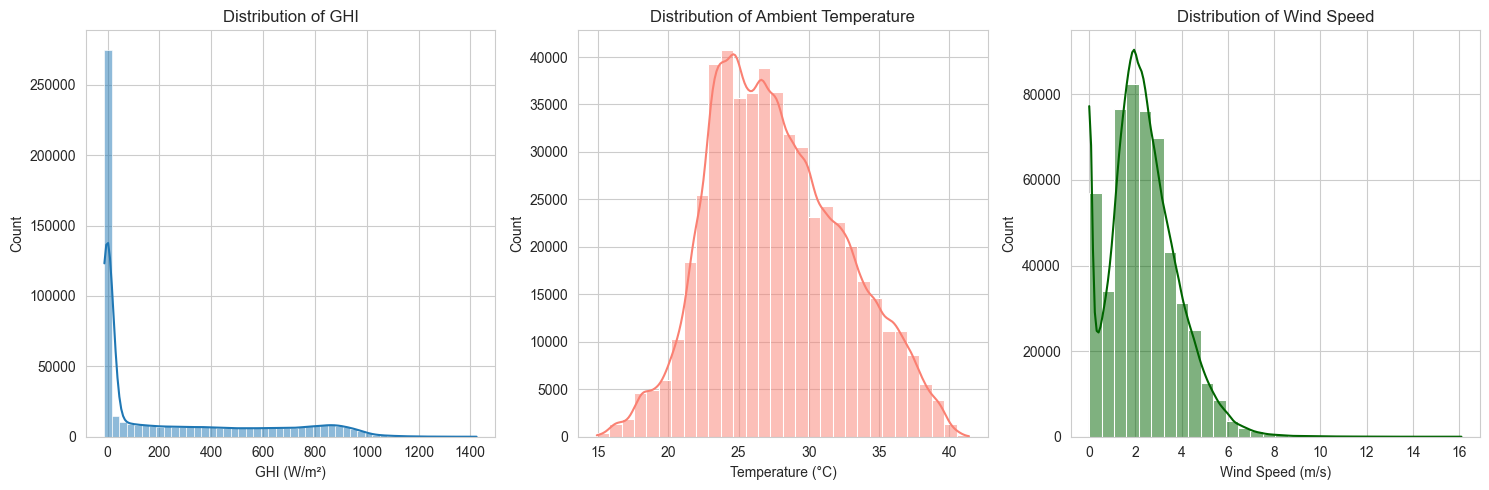

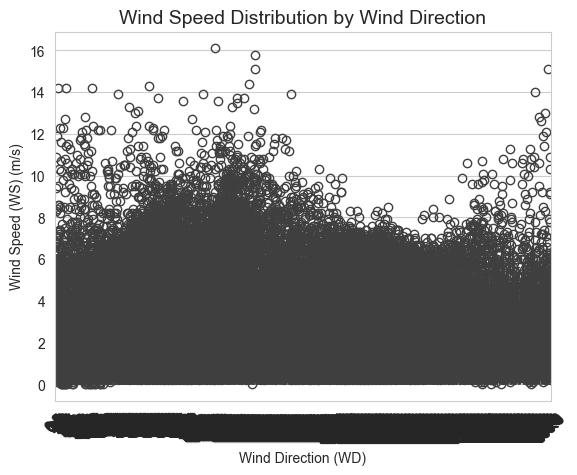

In [8]:


correlation_cols = ['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS', 'ModA', 'ModB']
corr_matrix = df[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            linewidths=.5, 
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Key Solar Farm Metrics (Sierra Leone)', fontsize=14)
plt.show()


# --- STEP 10: Wind & Distribution Analysis ---

# Distribution Plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['GHI'], kde=True, bins=50)
plt.title('Distribution of GHI', fontsize=12)
plt.xlabel('GHI (W/m²)')

plt.subplot(1, 3, 2)
sns.histplot(df['Tamb'], kde=True, bins=30, color='salmon')
plt.title('Distribution of Ambient Temperature', fontsize=12)
plt.xlabel('Temperature (°C)')

plt.subplot(1, 3, 3)
sns.histplot(df['WS'], kde=True, bins=30, color='darkgreen')
plt.title('Distribution of Wind Speed', fontsize=12)
plt.xlabel('Wind Speed (m/s)')

plt.tight_layout()
plt.show()

# Wind Direction Boxplot
sns.boxplot(x='WD', y='WS', data=df, order=sorted(df['WD'].dropna().unique()))
plt.title('Wind Speed Distribution by Wind Direction', fontsize=14)
plt.xlabel('Wind Direction (WD)')
plt.ylabel('Wind Speed (WS) (m/s)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

Temperature and Bubble chart

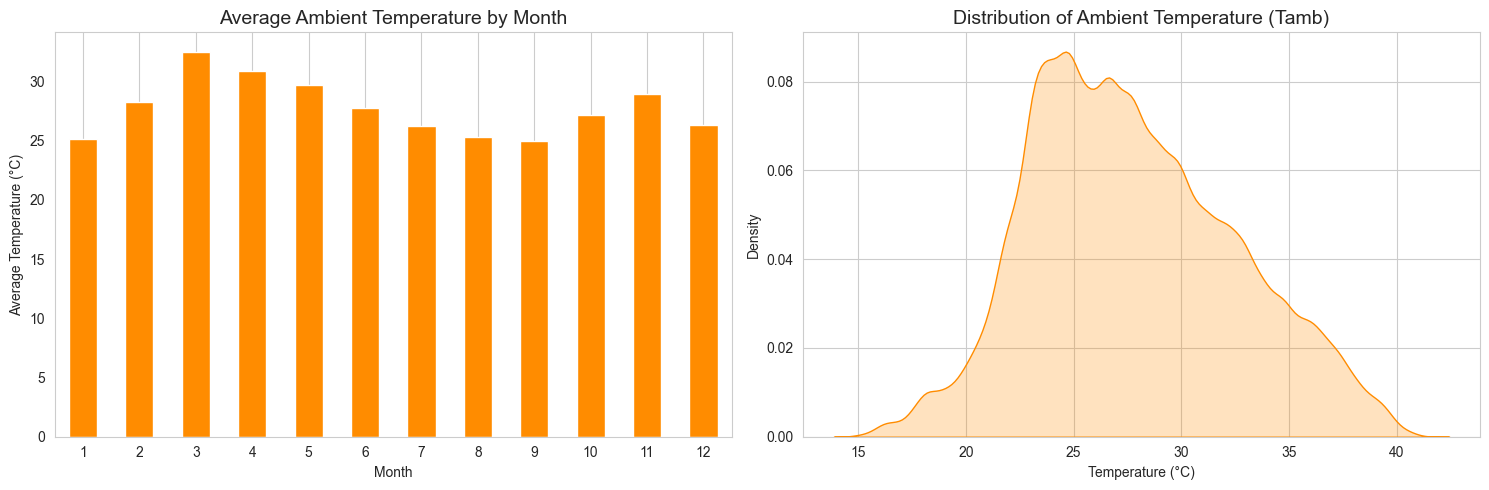

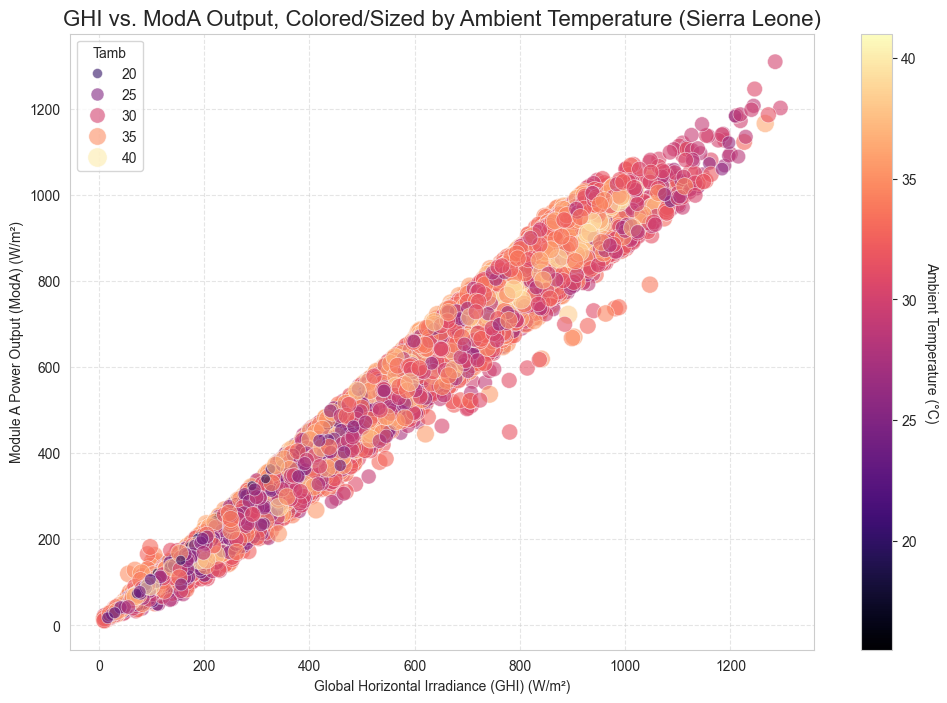

In [9]:
 
# Temperature Distribution & Diurnal Variation
plt.figure(figsize=(15, 5))

df['Month'] = df.index.month
monthly_temp = df.groupby('Month')['Tamb'].mean()

plt.subplot(1, 2, 1)
monthly_temp.plot(kind='bar', color='darkorange')
plt.title('Average Ambient Temperature by Month', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.subplot(1, 2, 2)
sns.kdeplot(df['Tamb'], fill=True, color='darkorange')
plt.title('Distribution of Ambient Temperature (Tamb)', fontsize=14)
plt.xlabel('Temperature (°C)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

df = df.drop(columns=['Month']) 
df = df.drop(columns=['Hour'])


# GHI vs. ModA/ModB with Temperature Overlay (Bubble Chart)
df_daylight = df[(df['GHI'] > 10) & (df['ModA'] > 0)].copy()
df_sample = df_daylight.sample(frac=0.05, random_state=42)

plt.figure(figsize=(12, 8))

scatter = sns.scatterplot(
    data=df_sample,
    x='GHI',
    y='ModA',
    hue='Tamb',        
    size='Tamb',       
    sizes=(20, 200),   
    palette='magma',   
    alpha=0.6,
    edgecolor='w',
    linewidth=0.5
)

norm = plt.Normalize(df_sample['Tamb'].min(), df_sample['Tamb'].max())
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])
cbar = scatter.figure.colorbar(sm, ax=scatter)
cbar.set_label('Ambient Temperature (°C)', rotation=270, labelpad=15)

plt.title('GHI vs. ModA Output, Colored/Sized by Ambient Temperature (Sierra Leone)', fontsize=16)
plt.xlabel('Global Horizontal Irradiance (GHI) (W/m²)')
plt.ylabel('Module A Power Output (ModA) (W/m²)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()